In [2]:
# instalação de bibliotecas
!pip install -U scikit-fuzzy

     |████████████████████████████████| 1.0MB 6.5MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894071 sha256=0797faf6fd94a76b4d44252de001ed39f6d4f775f474fad6e433cadd37632882
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [ ]:
# ==================================================================
# Universidade Estadual de Feira de Santana
# Mestrado em Ciência da Computação
# Disciplina: PGCC015 - Inteligência Computacional
# Professor: Matheus Giovanni Pires
# Aluno: Noberto Pires Maciel
# EPC06 - 20/11/2020
# Sistema de classificação Fuzzy Logic - Iris Plants
# ==================================================================

# instalação de bibliotecas
!pip install -U scikit-fuzzy

# Importacao das bibliotecas
import math
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from functools import reduce

def run(data_set_tra,data_set_tst,grafico=False):
    # Declaracao das variaveis globais
    N = 1
    cols = 4
    discretization = 100
    regioes = 2*N+1
    fuzz_sets = []
    step = []
    range_universe = []
    pertinencia = []
    indices_fuzzy = []
    attribute_range = []
    ax_range = []
    amostras = 0
    acuracia = 0
    # function tratamento dos dados dos atributos no arquivo .dat
    def manageAttrib(x,discretization=100):
      for el in x.values:
        stMin = str(el[0]).replace('[','').replace(',','')
        stMax = str(el[1]).replace(']','')
        min = float(stMin)
        max = float(stMax)
        step.append((max-min)/discretization)
        attribute_range.append((min,max))

    #Leitura dos atributos  do dataset no espaço (range)
    #@attribute SepalLength real [4.3, 7.9]
    #@attribute SepalWidth real [2.0, 4.4]
    #@attribute PetalLength real [1.0, 6.9]
    #@attribute PetalWidth real [0.1, 2.5]
    attribute_dat = pd.read_csv(data_set_tra, sep=' ', skiprows=1, nrows=4, header=None);
    manageAttrib(attribute_dat.iloc[:,3:5],discretization)

    # Leitura das amostras de treinamento
    data_set = pd.read_csv(data_set_tra, sep=',',skiprows=9, header=None, names=['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth','Output']);
    x_data_set = data_set.iloc[:,0:cols]
    y_data_set = data_set.iloc[:,cols:cols+1]
    y_data_set = y_data_set.to_numpy()

    # Leitura das amostras de teste
    tst_data_set = pd.read_csv(data_set_tst, sep=',',skiprows=9, header=None, names=['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth','Output']);
    tst_x_data_set = tst_data_set.iloc[:,0:cols]
    tst_y_data_set = tst_data_set.iloc[:,cols:cols+1]
    tst_y_data_set = tst_y_data_set.to_numpy()

    # separa os labels das classes (numericos e string)
    y_data_set_int = []
    y_data_set_str_tmp = []
    vlr = 0
    for z in range(len(y_data_set)):
      if y_data_set[z] not in y_data_set_str_tmp:
          y_data_set_str_tmp.append(y_data_set[z])
          vlr += 1
      y_data_set_int.append(vlr)


    # Distribuição dos atributos do dataset no espaço (range)
    for x in range(cols):
      range_universe.append(np.arange(attribute_range[x][0],attribute_range[x][1]+step[x]*2, step[x]))

    # Determinaçao dos índices dos valores inicial e final para composição do grafico da range_universe
    for x in range(cols):
        indices_fuzzy.append(len(range_universe[x])//(4*N))

    # Geraçao dos conjuntos fuzzy
    for x in range(cols):
      fuzz_region = []
      attrib = range_universe[x]
      index = indices_fuzzy[x]+1
      fuzz_region.append(fuzz.trimf(attrib, [attrib[0], attrib[0], attrib[index*2]]))
      for y in range(0,regioes,1):
        if index*(y+3) < len(range_universe[x]):
          fuzz_region.append(fuzz.trimf(attrib, [attrib[index], attrib[index*(y+2)], attrib[-index]])) # resolver largura desse trimf
        else: 
          break
      fuzz_region.append(fuzz.trimf(attrib, [attrib[index*2], attrib[-1], attrib[-1]]))
      fuzz_sets.append(fuzz_region)

    # Valores mínimo, máximo e medio de cada classe e atributo
    space_min = data_set.groupby(['Output']).min()
    space_max = data_set.groupby(['Output']).max()
    space_mean = data_set.groupby(['Output']).mean()

    # Calcular o grau de pertinencia das amostras
    #onde pertinencia[x][y][z], ou seja pertinencia[atributos][regioes][amostras]
    label = attribute_dat.iloc[:,1:2]
    for x in range(cols):
      value = x_data_set[label.iloc[x]]
      pertList = []
      for y in range(regioes):
        z_pert = []
        for z in range(len(x_data_set)):
          z_pert.append(fuzz.interp_membership(range_universe[x], fuzz_sets[x][y], value.iloc[z]))
        pertList.append(z_pert)
      pertinencia.append(pertList)

    # Geraçao dos graficos de range_universe
    if grafico is True:
        for x in range(cols):
          fig, (ax) = plt.subplots(nrows=1, figsize=(8, 3))
          ce = int(regioes//2)
          for y in range(regioes):
            if y == ce:
              lb = 'CE'
            elif y < ce:
              lb = 'S'+str(y)
            else:
              lb = 'B'+str(y)
            ax.plot(range_universe[x], fuzz_sets[x][y], linewidth=1.5, label=lb)
          ax.set_title(data_set.groupby(['Output']).min().columns[x])
          ax.legend()
          ax_range.append(ax)

    # gerar as regras pelo algoritmo de wang-mendel
    # onde array_max = [amostra][atributo ou coluna][regiao fuzzy]
    array_max = []
    for z in range(len(x_data_set)):
      cols_tmp = []
      for x in range(cols):
        region_tmp = []
        for y in range(regioes):
          region_tmp.append(pertinencia[x][y][z])
        cols_tmp.append(region_tmp)
      array_max.append(cols_tmp)

    regions_index = [] # array de indices das regioes vencedoras para n amostras por coluna/atributo
    for x in range(cols):
      index_tmp = []
      for z in range(len(x_data_set)):
        index_tmp.append(array_max[z][x].index(max(array_max[z][x])))
      regions_index.append(index_tmp)

    rules_index = [] # array de indices das regras e saidas (indices das classes)
    for x in range(cols):
      rules_index.append(regions_index[x])
    rules_index.append(y_data_set_int)

    rules = [] # array de regras
    for z in range(len(x_data_set)):
      rules_tmp = []
      for x in range(cols+1):
        rules_tmp.append(rules_index[x][z])
      rules.append(rules_tmp)

    # atribui grau às regras
    rules_grad = []
    def multiplicar(rules_grad_tmp_y):
      tmp = []
      for y in range(len(rules_grad_tmp_y)):
        if(rules_grad_tmp_y[y] != 0):
          tmp.append(rules_grad_tmp_y[y])
      return (reduce(lambda a, b: a*b, tmp) if len(tmp) > 1 else tmp)
    for z in range(len(x_data_set)):
      rules_grad_tmp_x = []
      for x in range(cols):
        rules_grad_tmp_y = []
        for y in range(regioes):
            rules_grad_tmp_y.append(float(pertinencia[x][y][z]))
        rules_grad_tmp_x.append(multiplicar(rules_grad_tmp_y))
      rules_grad.append(rules_grad_tmp_x)

    rules_unique = [list(x) for x in set(tuple(x) for x in rules)] # eliminar regras com menor grad
    rules_unique.reverse()

    # function de testagem
    def test(tst_x_data_set):
        test_pertinence =[]
        rules_unique
        for x in range(cols):
            value = tst_x_data_set[label.iloc[x]]
            test_pertinence.append(x)
            pertList = []
            for y in range(regioes):
              z_pert = []
              for z in range(len(tst_x_data_set)):
                z_pert.append(fuzz.interp_membership(range_universe[x], fuzz_sets[x][y], value.iloc[z]))
              pertList.append(z_pert)
            test_pertinence[x] = pertList

        array_max_test = []
        for z in range(len(tst_x_data_set)):
          cols_tmp = []
          for x in range(cols):
            region_tmp = []
            for y in range(regioes):
              region_tmp.append(test_pertinence[x][y][z])
            cols_tmp.append(region_tmp)
          array_max_test.append(cols_tmp)
        regions_index_test = []
        for x in range(cols):
          index_tmp = []
          for z in range(len(tst_x_data_set)):
            index_tmp.append(array_max[z][x].index(max(array_max[z][x])))
          regions_index_test.append(index_tmp)
        
        compare_regions_index = []
        for z in range(len(tst_x_data_set)):
          tmp_test = []
          for x in range(cols):
            tmp_test.append(regions_index_test[x][z])
          compare_regions_index.append(tmp_test)
        
        # compara as pertinencias com as regras
        acertos = 0
        erros = 0
        amostras = len(tst_x_data_set)
        for z in range(amostras):
            for x in range(0,len(rules_unique),1):
              if compare_regions_index[z] == rules_unique[x][0:4]:
                if tst_y_data_set[z] in y_data_set_str_tmp[rules_unique[x][-1]-1]:
                    acertos += 1
                else:
                    erros += 1
        acuracia = (acertos/amostras)*100
        print('amostras: ',amostras, ' acertos: ',acertos, ' erros: ',erros, ' acurácia: ', acuracia,'%')
        print('Quantidade de Regras: ',len(rules_unique))
        return amostras, acuracia

    # disparo do teste
    amostras, acuracia = test(tst_x_data_set)
    
    # Plotagem dos graficos
    if grafico is True:
        for ax in ax_range:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.get_xaxis().tick_bottom()
            ax.get_yaxis().tick_left()
        plt.tight_layout()

    return amostras, acuracia

acuracia_total = 0
xi = []
for x in range(1,11,1):
    grafico = False
    # apontamento dos arquivos do data set
    data_set_tra = 'https://raw.githubusercontent.com/PGCC-Uefs/PGCC015/master/iris-10-fold/iris-10-'+str(x)+'tra.dat'
    data_set_tst = 'https://raw.githubusercontent.com/PGCC-Uefs/PGCC015/master/iris-10-fold/iris-10-'+str(x)+'tst.dat'

    # inicia
    if x == 10:
      grafico = True

    amostras, acuracia = run(data_set_tra,data_set_tst,grafico)
    xi.append(acuracia)
    acuracia_total += acuracia

    media = acuracia_total/len(xi)
    d = 0
    for i in range(len(xi)):
        d += xi[i]-media

desvio_padrao = math.sqrt(d/len(xi))
print('media: ',media,'%', 'desvio padrão: ',desvio_padrao)



Antecedent: temperatura
Antecedent: volume
Consequent: pressao


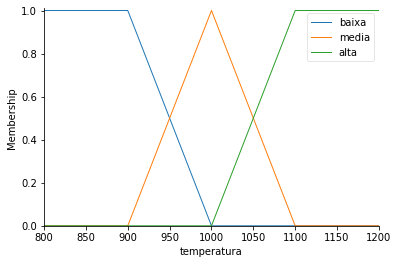

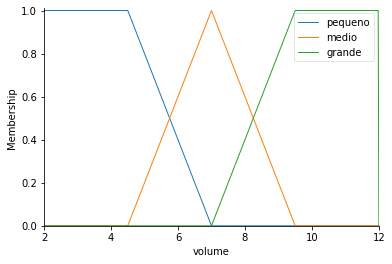

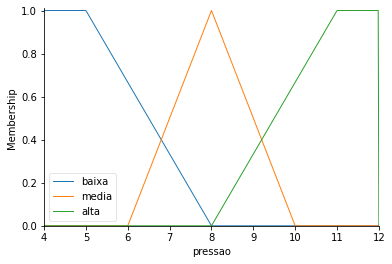

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl, interp_membership, interp_universe, defuzz

# temperatura [800, 1200]; volume [2,12]; pressao [4,12]
# 500 pontos de discretização para todos os universos abaixo
x_temp = np.arange(800, 1200.8, 0.8)
x_vol = np.arange(2, 12.02, 0.02)
x_pressao  = np.arange(4, 12.016, 0.016)

temperatura = ctrl.Antecedent(x_temp, 'temperatura')
volume = ctrl.Antecedent(x_vol, 'volume')
pressao = ctrl.Consequent(x_pressao, 'pressao')

print(temperatura)
print(volume)
print(pressao)

temperatura['baixa'] = fuzz.trapmf(temperatura.universe, [800, 800, 900, 1000])
temperatura['media'] = fuzz.trimf(temperatura.universe,  [900, 1000, 1100])
temperatura['alta'] = fuzz.trapmf(temperatura.universe, [1000, 1100, 1200, 1200])
volume['pequeno'] = fuzz.trapmf(volume.universe,  [2, 2, 4.5, 7])
volume['medio'] = fuzz.trimf(volume.universe,  [4.5, 7, 9.5])
volume['grande'] = fuzz.trapmf(volume.universe,  [7, 9.5, 12, 12])
pressao['baixa'] = fuzz.trapmf(pressao.universe,  [4, 4, 5, 8])
pressao['media'] = fuzz.trimf(pressao.universe, [6, 8, 10])
pressao['alta'] = fuzz.trapmf(pressao.universe,  [8, 11, 12, 12])

pressao.defuzzify_method = 'centroid'
pressao.accumulation_method = max

temperatura.view()
volume.view()
pressao.view()

# regras
regra1 = ctrl.Rule(temperatura['baixa'] & volume['pequeno'], pressao['baixa'])
regra2 = ctrl.Rule(temperatura['media'] & volume['pequeno'], pressao['baixa'])
regra3 = ctrl.Rule(temperatura['alta'] & volume['pequeno'], pressao['media'])
regra4 = ctrl.Rule(temperatura['baixa'] & volume['medio'], pressao['baixa'])
regra5 = ctrl.Rule(temperatura['media'] & volume['medio'], pressao['media'])
regra6 = ctrl.Rule(temperatura['alta'] & volume['medio'], pressao['alta'])
regra7 = ctrl.Rule(temperatura['baixa'] & volume['grande'], pressao['media'])
regra8 = ctrl.Rule(temperatura['media'] & volume['grande'], pressao['alta'])
regra9 = ctrl.Rule(temperatura['alta'] & volume['grande'], pressao['alta'])

pressao_ctrl = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5, regra6, regra7, regra8, regra9])
pressao_sim = ctrl.ControlSystemSimulation(pressao_ctrl)

# simulate (a) to (e) - [array_temp,array_vol]
simulate = [[965,920,1050,843,1122],[11,7.6,6.3,8.6,5.2]]

for x in range(len(simulate[0])):
  pressao_sim.input['temperatura'] = simulate[0][x]
  pressao_sim.input['volume'] = simulate[1][x]